# References

Pandas:

https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

https://pandas.pydata.org/docs/user_guide/timeseries.html

# import modules

In [2]:
# imports
import pandas as pd
import numpy as np

# full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas format
pd.set_option('display.float_format', '{:_.0f}'.format)
# NOTE: underscore separaters ('_') are better than commas (',') because 
# numbers with underscores work in Python without any extra effort.
pd.set_option('display.max_columns', None)

# plotting modules
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
%matplotlib inline
mpl.rcParams["axes.formatter.min_exponent"] = 20  # no scientific notation in graphs
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 10   # pad is in points... default is 6
import seaborn as sns
sns.set_theme()

stop wrapping text in tables / dataframes

In [3]:
%%html
<style>.dataframe td {white-space: nowrap;}</style>

# import data

In [4]:
# NOTE this file IS NOT ON GITHUB, it is too big, so it is in gitignore
# run the RV Database notebook to create this file from the cleaned tables

# entire database in one dataframe (df for simplicity)
df = pd.read_csv(
    'RV_DATABASE.csv', 
    dtype={'MATURITY':object, 
           'STRAT':object, 
           'TOTNO':'Int64', 
           'SPEC':'Int64',
           'SPECIMEN_ID':'Int64'},
    parse_dates=['DATETIME']  # need to parse the DATETIME field as pd.datetime format
)

# sort by datetime and reindex
df = df.sort_values('DATETIME').reset_index(drop=True)

In [5]:
# individual tables used to define the database
SPECIES = pd.read_csv('SPECIES.csv', index_col = 'index')
SPECIES.columns = ['SPEC', 'COMMON_NAME', 'SCIENTIFIC_NAME']
MISSIONS = pd.read_csv('MISSIONS.csv')
GSCAT = pd.read_csv('GSCAT.csv')
GSINF = pd.read_csv('GSINF.csv', index_col='date and time', parse_dates=['date and time'])  # parse index as pd.datetime format
GSINF.index.name = 'DATETIME'
GSDET = pd.read_csv('GSDET.csv')

# Functions

In [6]:
def get_species(species_code):
    return SPECIES[SPECIES.SPEC == species_code].COMMON_NAME.tolist()[0]

In [7]:
def search_species_by_name(name_contains):
    """returns a list of species that fit the query"""
    return SPECIES[SPECIES['COMMON_NAME'].str.contains(name_contains, case=False)]
    
search_species_by_name('cod')

,SPEC,COMMON_NAME,SCIENTIFIC_NAME
index,,,
10,10,COD(ATLANTIC),GADUS MORHUA
17,17,TOMCOD(ATLANTIC),MICROGADUS TOMCOD
110,110,ARCTIC COD,BOREOGADUS SAIDA
118,118,GREENLAND COD,GADUS OGAC


### Haul Weights, By Year or Month, by Species, with Graphs

In [8]:
# format dataframes
# could be improved, single function, loop through columns, look for 'PROP' etc, format 
# could deal with by_weight=True

def format_monthly(dataframe):
    return dataframe.style.format({
        'SPEC_TOTAL': '{:_.2f}'.format,
        'MONTH_TOTAL': '{:_.2f}'.format,
        'PROP_TOTAL': '{:.2%}'.format
    })

def format_yearly(dataframe):
    return dataframe.style.format({
        'SPEC_TOTAL': '{:_.2f}'.format,
        'YEAR_TOTAL': '{:_.2f}'.format,
        'PROP_TOTAL': '{:.2%}'.format
    })

In [9]:
def filtered_yearly(database, data_filter = None, by_weight=False):
    """
    assumes database is the main dataframe with the entire database
    data_filter needs the same dataframe name as database
        would be hard to repurpose this function, so not worth fixing
    data_filter is a boolean using the following syntax:
    data_filter = (database.DEPTH > 100) & (database.SPEED > 5) 
    """

    # total weight or total number?
    if by_weight == False:
        total_haul, total_to_drop = 'TOTNO', 'TOTWGT'
    else:
        total_haul, total_to_drop = 'TOTWGT', 'TOTNO'
    
    # columns to include
    columns = ['DATETIME', 'MISSION', 'SETNO', 'TOTWGT', 'TOTNO', 'SPEC', 'COMMON_NAME']

    # filter the data
    if type(data_filter) == type(None):
        haul_weights_filtered = database[columns].drop_duplicates()
    else:
        haul_weights_filtered = database[data_filter][columns].drop_duplicates()
      
    # weights by species
    yearly_weight_by_species = (
        haul_weights_filtered
        .drop(['SETNO', total_to_drop], axis=1)
        .groupby([haul_weights_filtered['DATETIME'].dt.year, 'SPEC']).sum()
    )
    yearly_weight_by_species = yearly_weight_by_species.reset_index(level=1)
    yearly_weight_by_species.index.names = ['YEAR']

    # total weights (filtered totals)
    yearly_weight_totals = (
        haul_weights_filtered
        .drop(['SETNO', total_to_drop, 'SPEC'], axis=1)
        .groupby([haul_weights_filtered['DATETIME'].dt.year]).sum()
    )
    yearly_weight_totals.index.names = ['YEAR']

    # join the two dataframes
    yearly_weight_by_species = (
        yearly_weight_by_species
        .merge(yearly_weight_totals, how='outer', on=['YEAR'])
        .rename(columns={f'{total_haul}_x': 'SPEC_TOTAL', f'{total_haul}_y': 'YEAR_TOTAL'})
    )

    # calculate the proportion of species to the total
    yearly_weight_by_species['PROP_TOTAL'] = (
        yearly_weight_by_species['SPEC_TOTAL'] / yearly_weight_by_species['YEAR_TOTAL']
    )

    return yearly_weight_by_species

In [10]:
def filtered_monthly(database, data_filter = None, by_weight=False):
    """
    assumes database is the main dataframe with the entire database
    data_filter needs the same dataframe name as database
        would be hard to repurpose this function, so not worth fixing
    data_filter is a boolean using the following syntax:
    data_filter = (database.DEPTH > 100) & (database.SPEED > 5) 
    """
    # total weight or total number?
    if by_weight == False:
        total_haul, total_to_drop = 'TOTNO', 'TOTWGT'
    else:
        total_haul, total_to_drop = 'TOTWGT', 'TOTNO'
    
    # columns to include
    columns = ['DATETIME', 'MISSION', 'SETNO', 'TOTWGT', 'TOTNO', 'SPEC', 'COMMON_NAME']

    # filter the data
    if type(data_filter) == type(None):
        haul_weights_filtered = database[columns].drop_duplicates()
    else:
        haul_weights_filtered = database[data_filter][columns].drop_duplicates()
      
    # weights by species
    monthly_weight_by_species = (
        haul_weights_filtered
        .drop(['SETNO', total_to_drop], axis=1)
        .groupby([haul_weights_filtered['DATETIME'].dt.year, haul_weights_filtered['DATETIME'].dt.month, 'SPEC']).sum()
    )
    monthly_weight_by_species = monthly_weight_by_species.reset_index(level=2)
    monthly_weight_by_species.index.names = ['YEAR', 'MONTH']

    # total weights (filtered totals)
    monthly_weight_totals = (
        haul_weights_filtered
        .drop(['SETNO', total_to_drop, 'SPEC'], axis=1)
        .groupby([haul_weights_filtered['DATETIME'].dt.year, haul_weights_filtered['DATETIME'].dt.month]).sum()
    )
    monthly_weight_totals.index.names = ['YEAR', 'MONTH']

    # join the two dataframes
    monthly_weight_by_species = monthly_weight_by_species
    monthly_weight_by_species = (
        monthly_weight_by_species
        .merge(monthly_weight_totals, how='outer', on=['YEAR', 'MONTH'])
        .rename(columns={f'{total_haul}_x': 'SPEC_TOTAL', f'{total_haul}_y': 'MONTH_TOTAL'})
    )

    # calculate the proportion of species to the total
    monthly_weight_by_species['PROP_TOTAL'] = (
        monthly_weight_by_species['SPEC_TOTAL'] / monthly_weight_by_species['MONTH_TOTAL']
    )

    return monthly_weight_by_species

In [11]:
def filter_by_species(dataframe, species_code):
    dataframe = dataframe[dataframe.SPEC == species_code].copy()
    dataframe.drop('SPEC', axis=1, inplace=True)  # remove SPEC label
    return dataframe

In [12]:
def graph_species(dataframe, species_code, title=None, ylabel=None):
    """
    takes in an unfiltered dataframe, filters it, and plots the data
    """
    
    # species input
    spec_no = species_code
    species = get_species(spec_no)
    
    # filter the data
    filtered_data = filter_by_species(dataframe, spec_no)
    
    # label overrides
    if title == None:
        title=f'Proportion of Haul. Species: {species}.'
    if ylabel == None:
        ylabel='Proportion of Total'
    
    # graph the proportion of haul by species by year
    dataframe[dataframe.SPEC == spec_no].plot(
        kind='bar',
        width=1,
        y='PROP_TOTAL', 
        ylabel=ylabel,
        figsize=(30, 8), 
        legend=False, 
        title=title
    );

### Testine Filtering and Graphing

In [13]:
filtered_monthly(df).head()

SPEC  SPEC_TOTAL  MONTH_TOTAL  PROP_TOTAL
YEAR MONTH                                           
1970 7        10        2086        48872           0
     7        11        2166        48872           0
     7        12         790        48872           0
     7        13          20        48872           0
     7        14        3106        48872           0

In [14]:
filtered_yearly(df).head()

,SPEC,SPEC_TOTAL,YEAR_TOTAL,PROP_TOTAL
YEAR,,,,
1970,10,2086,48872,0
1970,11,2166,48872,0
1970,12,790,48872,0
1970,13,20,48872,0
1970,14,3106,48872,0


In [15]:
filter_by_species(filtered_yearly(df), 10).head()

,SPEC_TOTAL,YEAR_TOTAL,PROP_TOTAL
YEAR,,,
1970,2086,48872,0
1971,2058,39202,0
1972,2034,52241,0
1973,5869,42214,0
1974,3128,44950,0


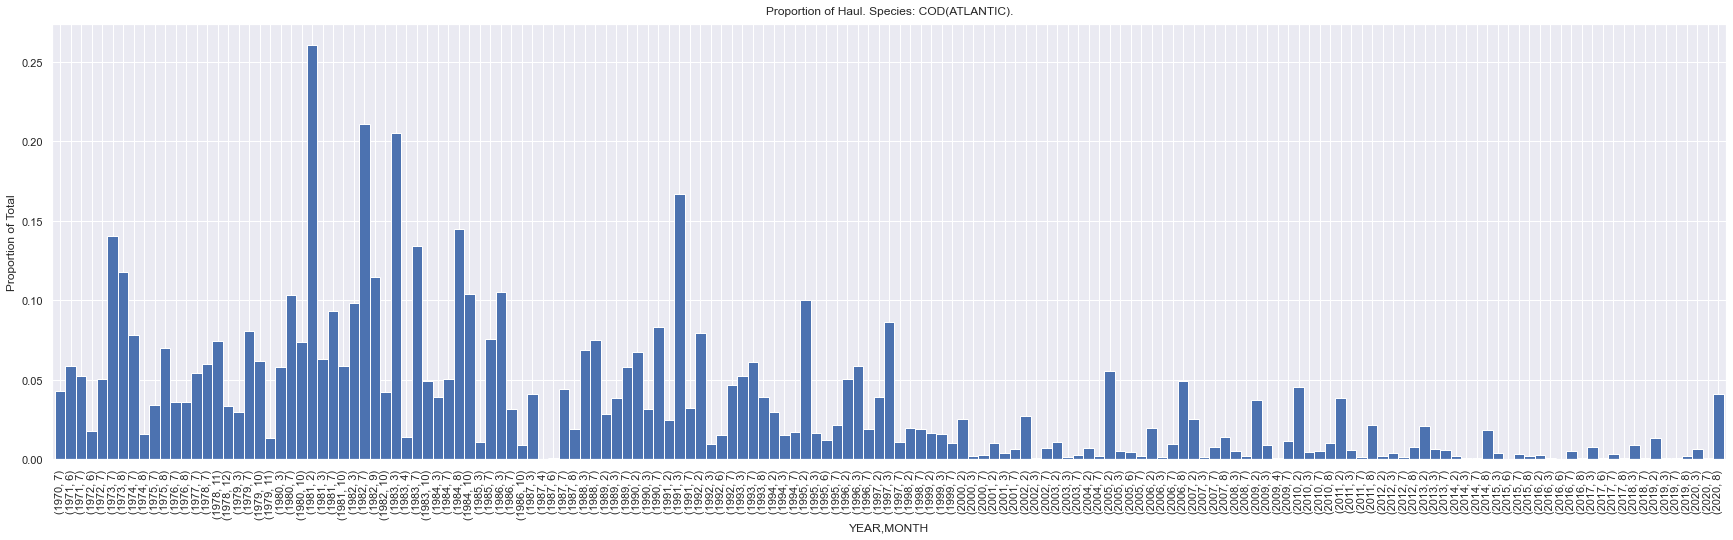

In [16]:
graph_species(filtered_monthly(df), 10)

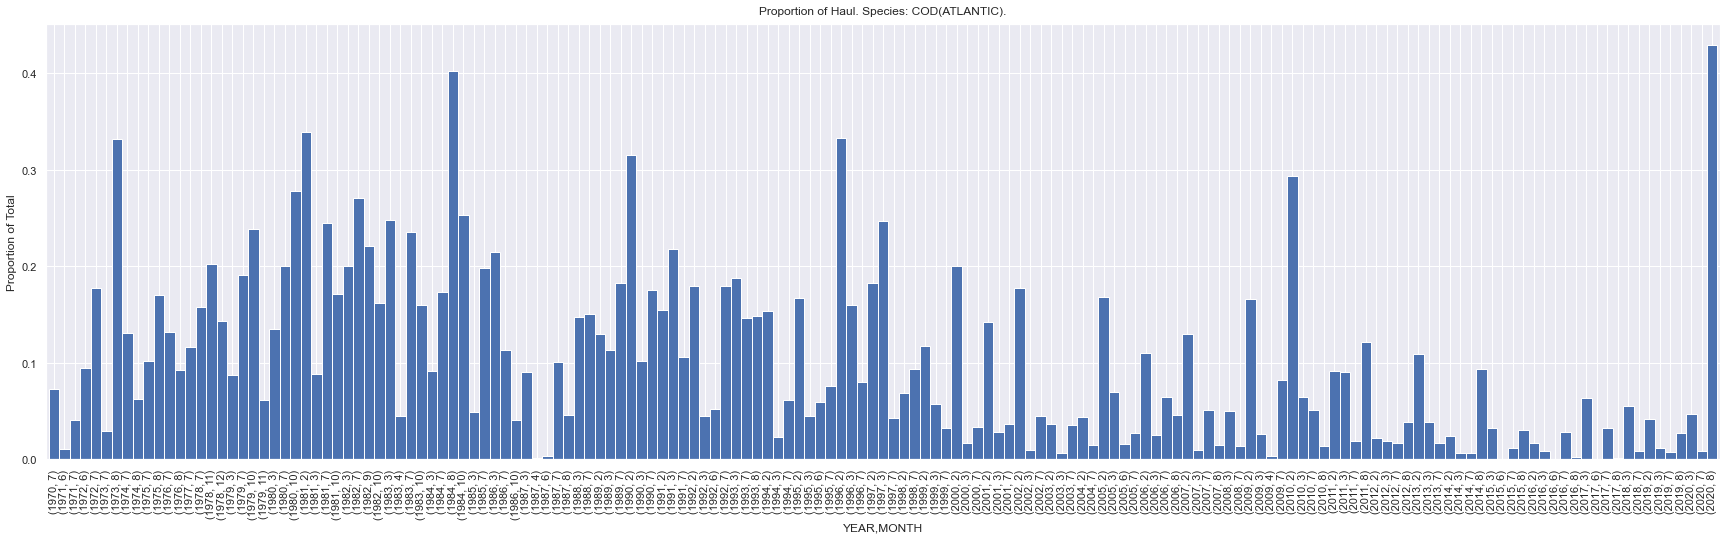

In [17]:
graph_species(filtered_monthly(df, by_weight=True), 10)

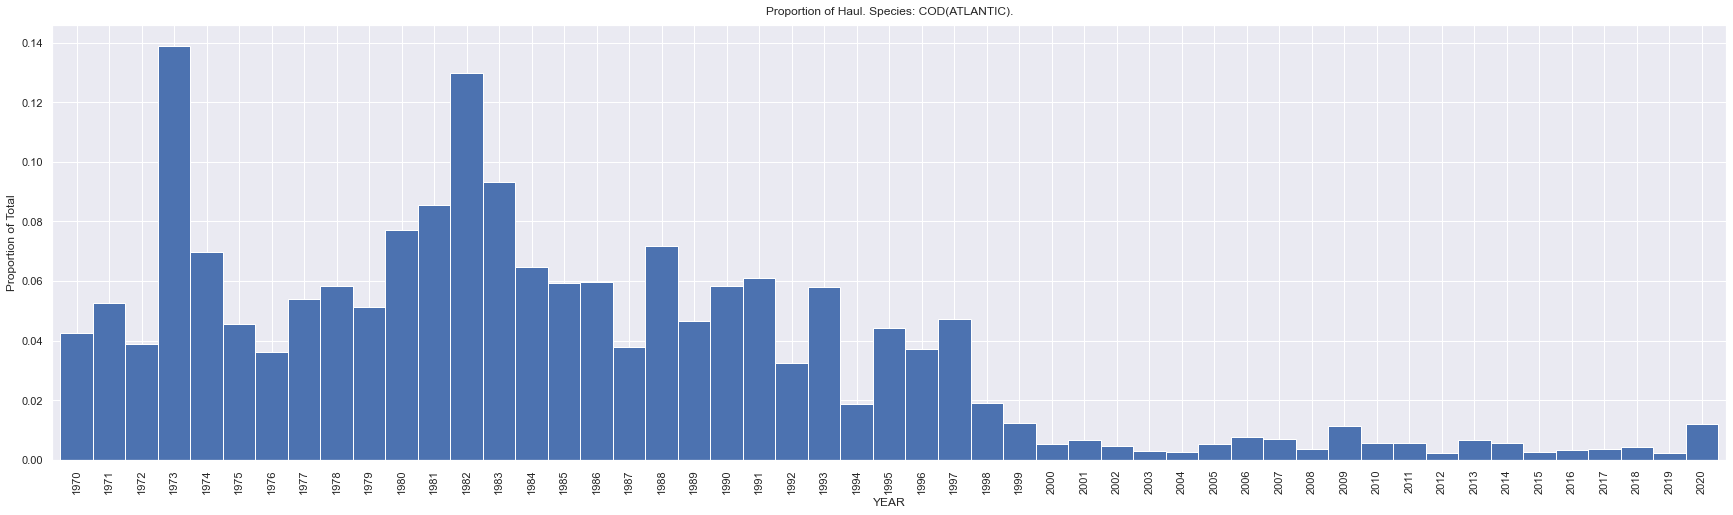

In [18]:
graph_species(filtered_yearly(df), 10)

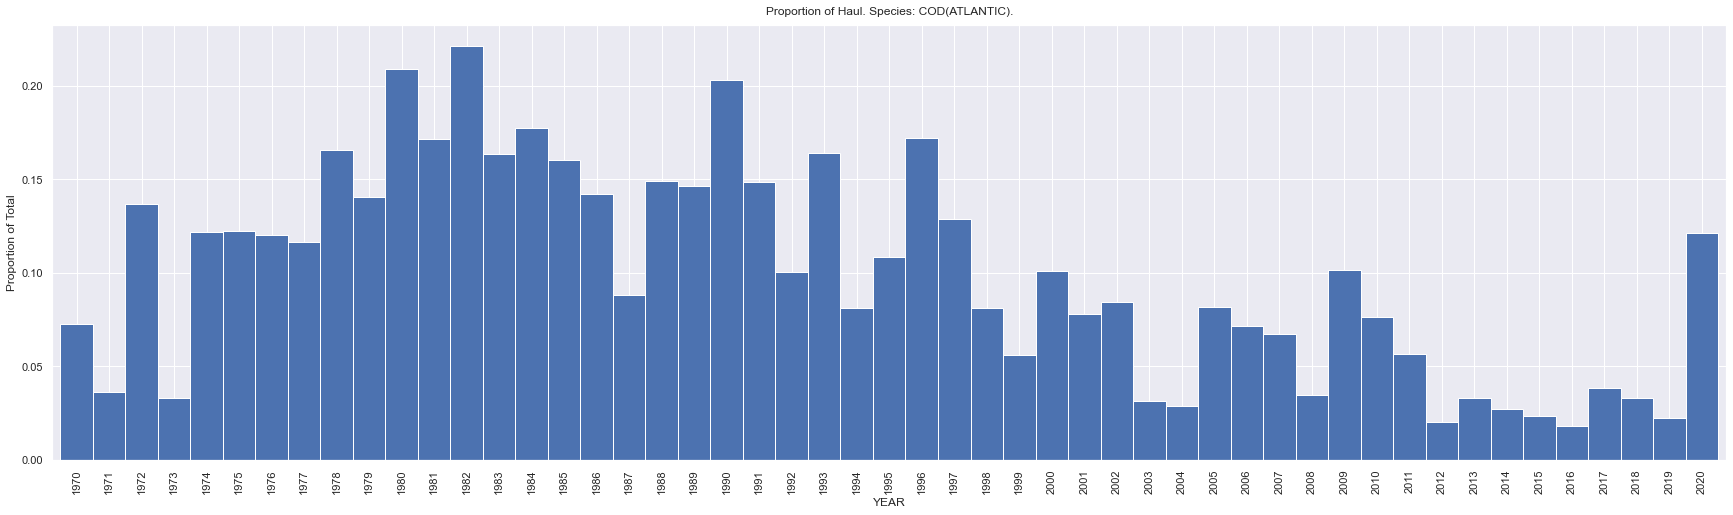

In [19]:
graph_species(filtered_yearly(df, by_weight=True), 10)

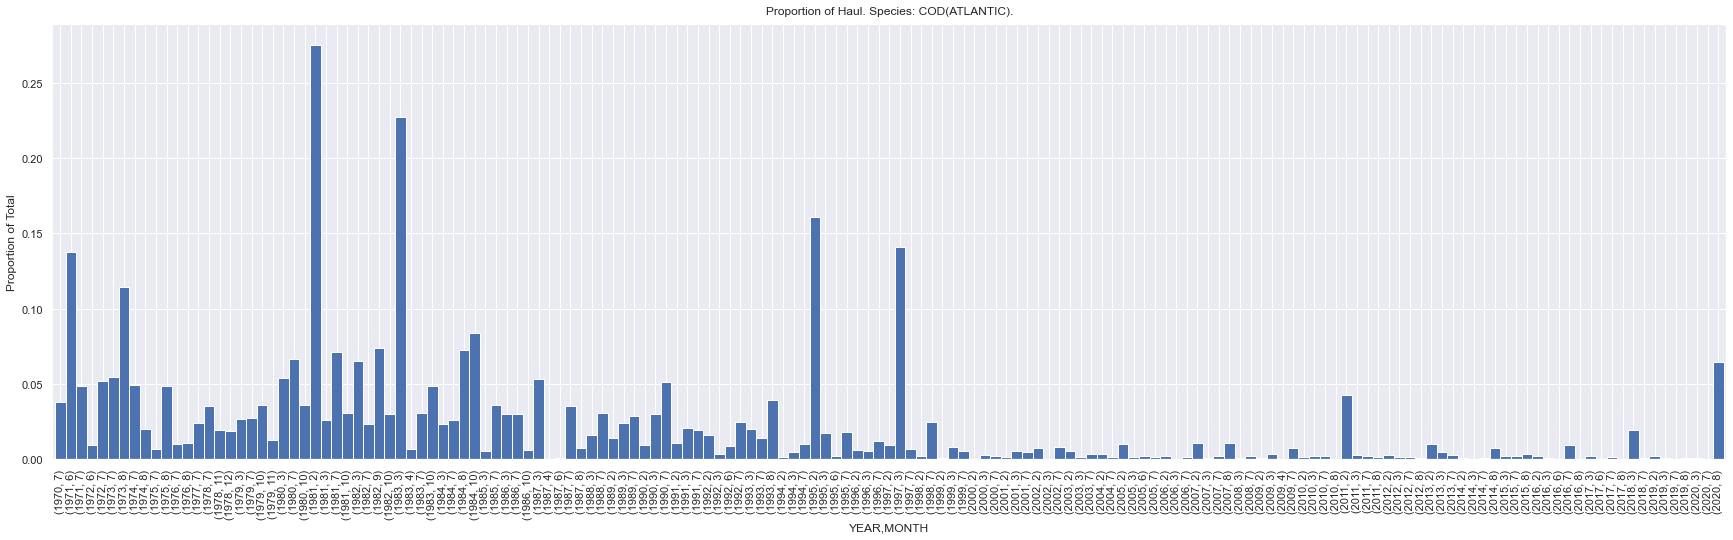

In [20]:
# check filter works
data_filter = (df.DEPTH > 100)
graph_species(filtered_monthly(df, data_filter), 10)

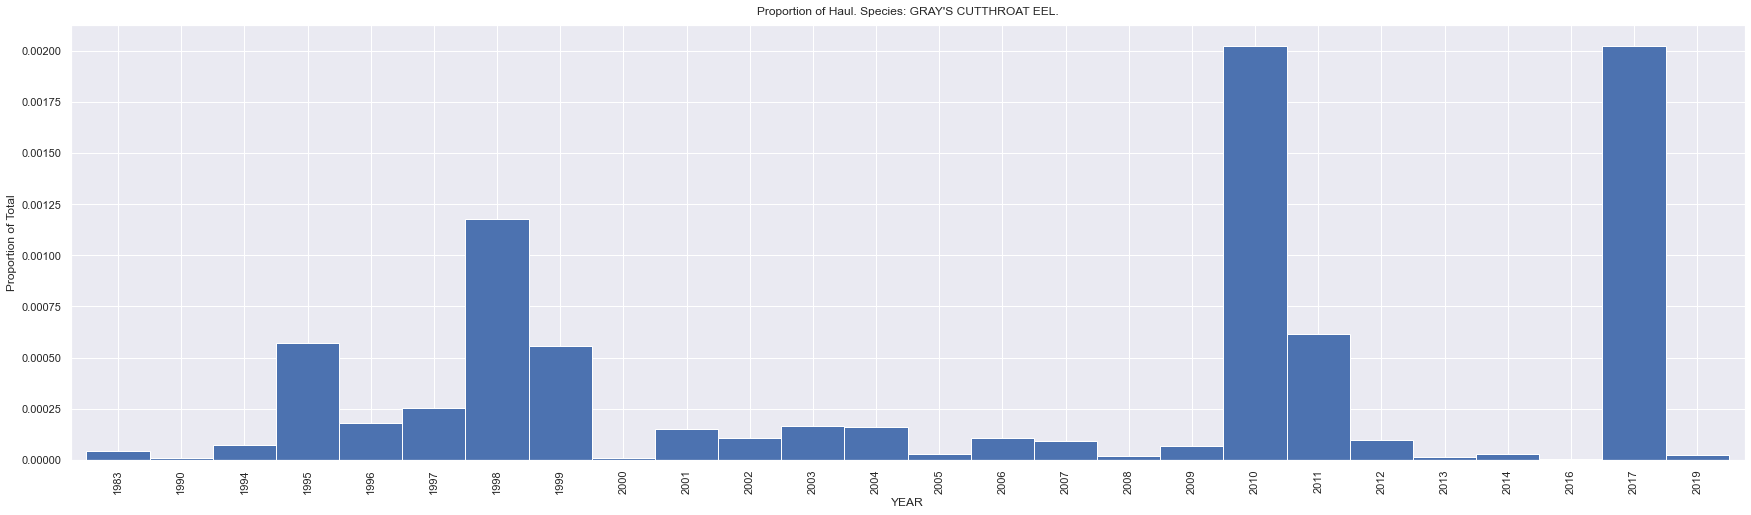

In [21]:
# check filter works
data_filter = (df.DEPTH > 100)
graph_species(filtered_yearly(df, data_filter), 602)

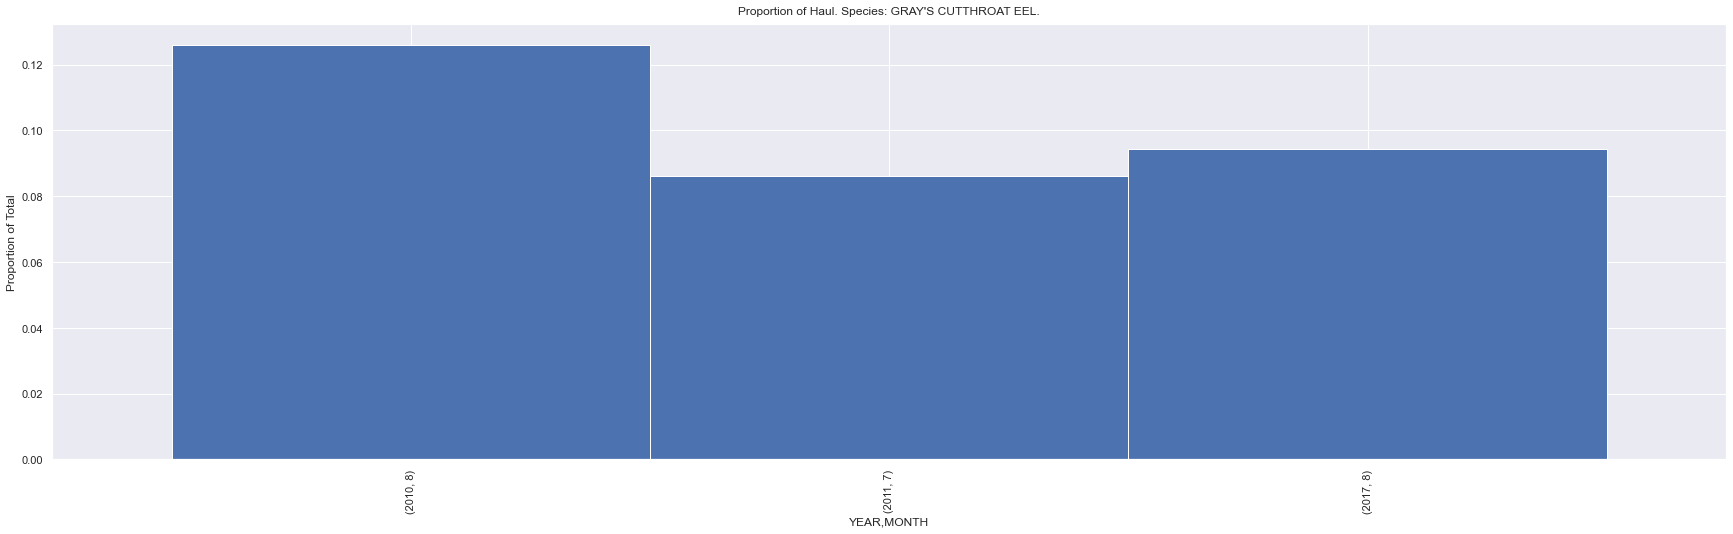

In [22]:
# which months were this super deep eel caught?
graph_species(filtered_monthly(df, df.DEPTH > 1000), 602)

In [23]:
# check percentages
data_filter = (df.DEPTH > 1800)
test = filtered_monthly(df, data_filter)
year_month = (2010, 8)
print(test[test.index == year_month].PROP_TOTAL.sum())
print()
format_monthly(test[test.index == year_month].sort_values('PROP_TOTAL', ascending=False).head(10))

1.0



In [24]:
# check percentages
data_filter = (df.DEPTH > 1800)
test = filtered_monthly(df, data_filter, by_weight=True)
year_month = (2010, 8)
print(test[test.index == year_month].PROP_TOTAL.sum())
print()
format_monthly(test[test.index == year_month].sort_values('PROP_TOTAL', ascending=False).head(10))

1.0000000000000002



# Descriptive Statistics Function

In [25]:
def describe_species_all(dataframe, species_code):
    """descriptive stats for all columns. Many NaN with this method"""
    
    all_columns = ['SPEC', 'COMMON_NAME', 'SCIENTIFIC_NAME', 'FLEN', 'FWT', 'AGE',
        'SLAT', 'SLONG', 'ELAT', 'ELONG', 'DEPTH', 'SURF_TEMP', 'BOTT_TEMP', 'BOTT_SAL',
        'MATURITY', 'SEX', 'STRAT']  # object columns

    df_all = dataframe[all_columns][dataframe.SPEC == species_code]

    # count row is dropped for display purposes, but may be useful
    return df_all.describe(include='all').drop('count') 

describe_species_all(df, 10)

,SPEC,COMMON_NAME,SCIENTIFIC_NAME,FLEN,FWT,AGE,SLAT,SLONG,ELAT,ELONG,DEPTH,SURF_TEMP,BOTT_TEMP,BOTT_SAL,MATURITY,SEX,STRAT
unique,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,4,86
top,NaN,COD(ATLANTIC),GADUS MORHUA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Resting,FEMALE,5Z2
freq,NaN,119753,119753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21151,48968,18105
mean,10,NaN,NaN,50,1_807,4,44,-63,43,-63,105,11,5,33,NaN,NaN,NaN
std,0,NaN,NaN,19,2_227,2,1,3,2,3,58,6,3,1,NaN,NaN,NaN
min,10,NaN,NaN,2,0,0,40,-70,40,-70,22,-2,-2,-99,NaN,NaN,NaN
25%,10,NaN,NaN,37,492,3,43,-66,42,-66,68,5,3,32,NaN,NaN,NaN
50%,10,NaN,NaN,49,1_120,4,44,-61,43,-66,86,12,5,33,NaN,NaN,NaN
75%,10,NaN,NaN,61,2_200,5,45,-60,45,-60,130,15,6,33,NaN,NaN,NaN
max,10,NaN,NaN,161,38_000,20,48,-57,47,-57,507,22,17,36,NaN,NaN,NaN


In [26]:
def describe_species(dataframe, species_code):
    """descriptive stats for numeric columns"""
    
    numeric_columns = ['SPEC', 'COMMON_NAME', 'SCIENTIFIC_NAME', 'FLEN', 'FWT', 'AGE',
        'SLAT', 'SLONG', 'ELAT', 'ELONG', 'DEPTH', 'SURF_TEMP', 'BOTT_TEMP', 'BOTT_SAL']

    df_numeric = dataframe[numeric_columns][dataframe.SPEC == species_code]

    # count row is dropped for display purposes, but may be useful
    return df_numeric.describe().drop('count')

# describe_species(df, 10)


def species_counts(dataframe, species_code):
    """for object data that won't appear in df.describe() along with numeric fields"""
        
    object_columns = ['MATURITY', 'SEX', 'STRAT']
    df_object = dataframe[object_columns][dataframe.SPEC == species_code]
    
    dict_of_unique = {}
    
    for i in object_columns:
        dict_of_unique[i] = df_object[i].value_counts()
    
    return dict_of_unique

# species_counts(df, 10)


def print_species_data(dataframe, species_code):
    
    print('\n', get_species(species_code))
    
    df_describe = describe_species(dataframe, species_code)
    df_count = species_counts(dataframe, species_code)
    
    # display numeric data
    display(df_describe.drop('SPEC', axis=1).style.format({
        'FLEN': '{:_.2f}'.format,
        'FWT': '{:_.2f}'.format,
        'AGE': '{:_.2f}'.format,
        'DEPTH': '{:_.2f}'.format,
        'SURF_TEMP': '{:_.2f}'.format,
        'BOTT_TEMP': '{:_.2f}'.format,
        'BOTT_SAL': '{:_.2f}'.format,
        'SLONG': '{:_.5f}'.format,
        'SLAT': '{:_.5f}'.format
    }))
    
    # display object counts
    for key in df_count.keys():
        display(pd.DataFrame(df_count[key]))
    
# print_species_data(df, 10)

### Testing Descriptive Statistics

In [27]:
print_species_data(df, 10)


 COD(ATLANTIC)


,FLEN,FWT,AGE,SLAT,SLONG,ELAT,ELONG,DEPTH,SURF_TEMP,BOTT_TEMP,BOTT_SAL
mean,49.67,1_806.80,4.09,43.88246,-62.51333,43.444762,-63.450219,104.73,10.63,4.87,32.93
std,18.81,2_226.74,2.00,1.47821,3.40791,1.601751,3.495063,57.68,5.76,2.51,0.92
min,2.00,0.30,0.00,40.31850,-69.98167,40.297833,-69.970000,21.95,-1.68,-1.53,-99.00
25%,37.00,492.00,3.00,42.63333,-66.22800,41.974167,-66.459833,67.67,4.90,3.03,32.38
50%,49.00,1_120.00,4.00,44.03333,-61.16667,43.394833,-65.578833,85.95,12.50,4.67,32.85
75%,61.00,2_200.00,5.00,44.83800,-59.51667,44.537500,-60.119000,129.84,15.30,6.41,33.40
max,161.00,38_000.00,20.00,47.85000,-56.55800,47.189000,-56.539667,507.49,21.84,16.70,35.56


,MATURITY
Resting,21151
Immature,20899
Recovering,8248
Ripening 1,6871
Ripening 2,5125
Spent,4323
Ripe (Mature),3581
Spawning (Running),3439
Undetermined,27


,SEX
FEMALE,48968
MALE,48683
UNKNOWN,10586
BERRIED FEMALE,2


,STRAT
5Z2,18105
441,7507
455,7397
444,4870
447,4765
...,...
439,4
396,4
5Z8,3
436,2


In [28]:
print_species_data(df, 602)


 GRAY'S CUTTHROAT EEL


,FLEN,FWT,AGE,SLAT,SLONG,ELAT,ELONG,DEPTH,SURF_TEMP,BOTT_TEMP,BOTT_SAL
mean,43.17,75.69,nan,42.86308,-62.59036,42.863599,-62.602674,976.90,15.35,5.20,34.93
std,10.50,62.05,nan,0.50209,1.75039,0.493916,1.727133,368.53,3.52,0.86,0.12
min,9.00,1.00,nan,40.06983,-69.97417,40.097000,-69.978667,76.81,-0.50,4.28,33.61
25%,35.00,28.00,nan,42.64917,-63.86617,42.648500,-63.881833,642.82,14.56,4.63,34.92
50%,42.00,54.00,nan,42.71267,-63.37733,42.713500,-63.303167,908.00,15.63,4.92,34.94
75%,51.00,110.00,nan,42.84500,-62.01133,42.845167,-61.940000,1_313.99,17.30,5.24,34.97
max,76.00,450.00,nan,45.52283,-56.95250,45.515833,-56.928000,1_805.94,20.97,10.77,35.17


,MATURITY
Undetermined,20


,SEX
UNKNOWN,41


,STRAT
501,343
502,340
498,328
503,319
504,193
497,156
496,134
397,12
451,8
404,7


# Mapping and Visualisation Functions

### checking whether to interpolate, average, or draw a line

In [29]:
# check variance in SLONG vs ELONG and SLAT vs ELAT
# should we take an average, use both, use one?

geo_columns = ['SLONG', 'ELONG', 'SLAT', 'ELAT']

df_geo = df[geo_columns].copy()
df_geo['LONG_DIFF'] = df_geo['ELONG'] - df_geo['SLONG'] 
df_geo['LAT_DIFF'] = df_geo['ELAT'] - df_geo['SLAT'] 

df_geo[['LONG_DIFF', 'LAT_DIFF']].describe().style.format()

,LONG_DIFF,LAT_DIFF
count,1726156.000000,1726156.000000
mean,0.000869,0.000029
std,0.028723,0.020090
min,-0.177833,-0.042834
25%,-0.027500,-0.019167
50%,0.001667,-0.000167
75%,0.029166,0.019666
max,0.077000,0.195000


In [30]:
# degrees latitude are approximately 110km
# longitude varies by latitude

min(df.SLAT.min(), df.ELAT.min()), max(df.SLAT.max(), df.ELAT.max())
# at ~45 degrees lat, 1 degree longitude is approx 80km

(39.971333, 47.85)

In [31]:
geo_columns = ['SLONG', 'ELONG', 'SLAT', 'ELAT']

df_geo = df[geo_columns].copy()
df_geo['LONG_DIFF'] = (df_geo['ELONG'] - df_geo['SLONG']) * 80 
df_geo['LAT_DIFF'] = (df_geo['ELAT'] - df_geo['SLAT']) * 110

df_geo[['LONG_DIFF', 'LAT_DIFF']].describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75, .9, .95, .99]).drop('count').style.format()

,LONG_DIFF,LAT_DIFF
mean,0.069482,0.003159
std,2.297847,2.209879
min,-14.226640,-4.711740
1%,-3.320000,-3.300000
5%,-3.160000,-3.153260
10%,-3.000000,-2.970000
25%,-2.200000,-2.108370
50%,0.133360,-0.018370
75%,2.333280,2.163260
90%,3.026640,2.988370


In [32]:
# 95th Percentile is approx 3 km
df_geo[['LONG_DIFF', 'LAT_DIFF']].describe(percentiles=[0.025, .975]).drop(['count', 'mean', 'std', '50%', 'min', 'max']).style.format()

,LONG_DIFF,LAT_DIFF
2.5%,-3.240000,-3.226630
97.5%,3.253360,3.226630


In [33]:
# 4km hypotenuse 
(3*3 + 3*3)**0.5

4.242640687119285

In [34]:
# max 7.4 km total distance
# converted from nautical miles to km
pd.DataFrame((df.DIST*1.852).describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75, .9, .95, .99])).drop('count').style.format()

,DIST
mean,3.226031
std,0.379222
min,1.092680
1%,2.111280
5%,2.592800
10%,2.963200
25%,3.148400
50%,3.241000
75%,3.333600
90%,3.444720


In [35]:
# may be easier to average start and end lat/long
# may be a way to interpolate from start to end of tow

df[(df.SPEC==10)&(df.MISSION=='NED2010001')&(df.SETNO==3)&(df.DATETIME.dt.year==2010)]

,DATETIME,SEASON,MISSION,SETNO,TOTWGT,TOTNO,SPEC,COMMON_NAME,SCIENTIFIC_NAME,FLEN,FWT,MATURITY,SEX,AGE,SPECIMEN_ID,STRAT,SLAT,SLONG,ELAT,ELONG,DUR,DIST,SPEED,DEPTH,SURF_TEMP,BOTT_TEMP,BOTT_SAL,GEARDESC,VESEL,CRUNO,YEAR
1431366,2010-02-27 02:38:00,SPRING,NED2010001,3,28,10,10,COD(ATLANTIC),GADUS MORHUA,82,4_290,Ripe (Mature),FEMALE,7,<NA>,5Z2,42,-66,42,-66,30,2,3,80,5,6,33,Western IIA trawl,N,1,2010
1431367,2010-02-27 02:38:00,SPRING,NED2010001,3,28,10,10,COD(ATLANTIC),GADUS MORHUA,77,3_585,Spent,FEMALE,5,<NA>,5Z2,42,-66,42,-66,30,2,3,80,5,6,33,Western IIA trawl,N,1,2010
1431384,2010-02-27 02:38:00,SPRING,NED2010001,3,28,10,10,COD(ATLANTIC),GADUS MORHUA,71,3_352,Spent,MALE,4,<NA>,5Z2,42,-66,42,-66,30,2,3,80,5,6,33,Western IIA trawl,N,1,2010
1431387,2010-02-27 02:38:00,SPRING,NED2010001,3,28,10,10,COD(ATLANTIC),GADUS MORHUA,101,8_570,Spent,FEMALE,10,<NA>,5Z2,42,-66,42,-66,30,2,3,80,5,6,33,Western IIA trawl,N,1,2010
1431390,2010-02-27 02:38:00,SPRING,NED2010001,3,28,10,10,COD(ATLANTIC),GADUS MORHUA,44,696,Immature,FEMALE,2,<NA>,5Z2,42,-66,42,-66,30,2,3,80,5,6,33,Western IIA trawl,N,1,2010
1431410,2010-02-27 02:38:00,SPRING,NED2010001,3,28,10,10,COD(ATLANTIC),GADUS MORHUA,49,1_072,Resting,FEMALE,3,<NA>,5Z2,42,-66,42,-66,30,2,3,80,5,6,33,Western IIA trawl,N,1,2010
1431411,2010-02-27 02:38:00,SPRING,NED2010001,3,28,10,10,COD(ATLANTIC),GADUS MORHUA,52,1_226,Resting,FEMALE,4,<NA>,5Z2,42,-66,42,-66,30,2,3,80,5,6,33,Western IIA trawl,N,1,2010
1431412,2010-02-27 02:38:00,SPRING,NED2010001,3,28,10,10,COD(ATLANTIC),GADUS MORHUA,53,NaN,Recovering,MALE,5,<NA>,5Z2,42,-66,42,-66,30,2,3,80,5,6,33,Western IIA trawl,N,1,2010
1431429,2010-02-27 02:38:00,SPRING,NED2010001,3,28,10,10,COD(ATLANTIC),GADUS MORHUA,40,538,Immature,MALE,3,<NA>,5Z2,42,-66,42,-66,30,2,3,80,5,6,33,Western IIA trawl,N,1,2010
1431490,2010-02-27 02:38:00,SPRING,NED2010001,3,28,10,10,COD(ATLANTIC),GADUS MORHUA,72,3_294,Spent,MALE,7,<NA>,5Z2,42,-66,42,-66,30,2,3,80,5,6,33,Western IIA trawl,N,1,2010


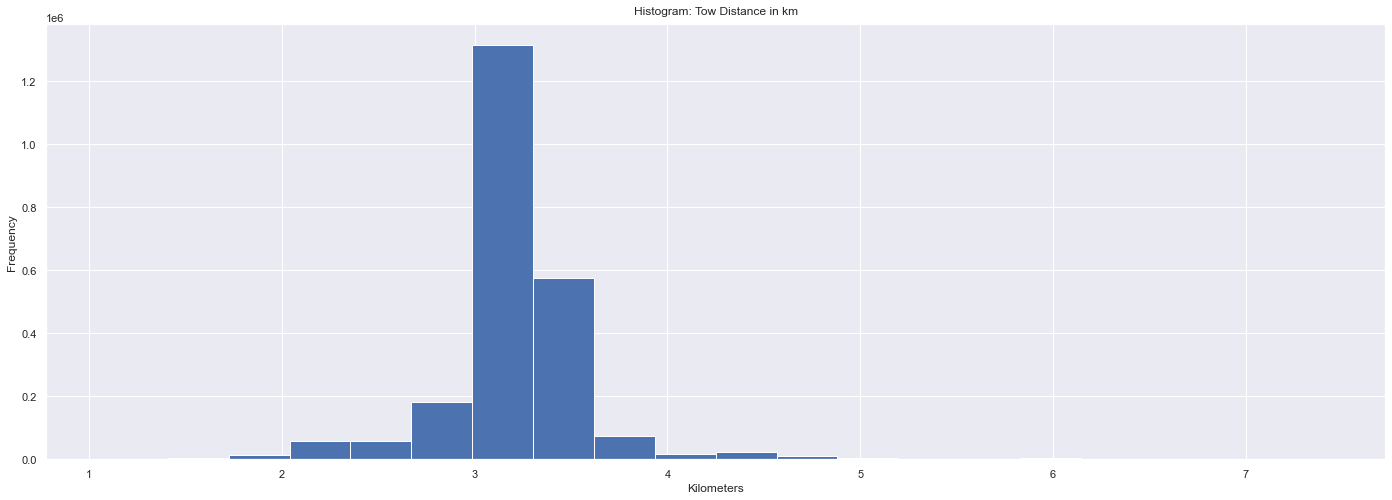

In [36]:
# the vast majority of tows are the same distance - approx 3km
pd.DataFrame(df.DIST*1.852).plot(kind='hist', bins=20, figsize=(24,8), legend=False, title='Histogram: Tow Distance in km');
plt.xlabel('Kilometers');

    Is 3km too much? 
        averaged values will be off by 0 to 1.5km on average (just under 1 km on average)
        is this OK?
        
    There is no way to accurately interpolate the exact value (no exact timestamps for specimens)
        interpolating is not feasible
        
    The other option is plotting a line from start to end, along which the species was obtained
        This is likely to make for a more confusing and difficult visualisation
        however, this may be a better option


In [37]:
# there are almost 10_000 distinct points where Cod were found
# could be difficult to display 10k lines, points are probably a better proxy
# could also scale the point by how many were found there
df[(df.SPEC == 10)][['SLAT', 'SLONG']].drop_duplicates()

,SLAT,SLONG
0,45,-67
108,45,-65
110,45,-65
255,45,-66
369,45,-66
...,...,...
2343171,44,-57
2343295,44,-58
2344074,44,-58
2346340,45,-60


### mapping functions

In [38]:
# potential columns that may be useful for mapping function

mapping_columns = ['DATETIME', 'MISSION',  # MISSION data
                   'SETNO', 'TOTWGT', 'TOTNO',  # SETNO specific info
                   'SPEC', 'FLEN', 'FWT', 'MATURITY', 'SEX', 'AGE', 'SPECIMEN_ID',  # SPEC info, can lookup COMMON_NAME and SCIENTIFIC_NAME
                   'SLAT', 'SLONG', 'ELAT', 'ELONG',  # lat/long: may be best to average these for mapping
                   'STRAT', 'DUR', 'DIST', 'SPEED', 'DEPTH', 'SURF_TEMP', 'BOTT_TEMP', 'BOTT_SAL']  # tow info

In [39]:
# helper functions

def average_geo(dataframe):
    """
    averages SLAT and ELAT & SLONG and ELONG
    null values do not get averaged
    """
    geo_df = dataframe
    geo_df['LAT'] = geo_df[['SLAT', 'ELAT']].mean(axis=1)
    geo_df['LONG'] = geo_df[['SLONG', 'ELONG']].mean(axis=1)
    return geo_df.drop(['SLAT', 'ELAT', 'SLONG', 'ELONG'], axis=1)

temp = average_geo(df)
temp.tail().style.format({})
# temp.LONG.isna().sum()

,DATETIME,SEASON,MISSION,SETNO,TOTWGT,TOTNO,SPEC,COMMON_NAME,SCIENTIFIC_NAME,FLEN,FWT,MATURITY,SEX,AGE,SPECIMEN_ID,STRAT,DUR,DIST,SPEED,DEPTH,SURF_TEMP,BOTT_TEMP,BOTT_SAL,GEARDESC,VESEL,CRUNO,YEAR,LAT,LONG
2346734,2020-08-07 10:52:00,SUMMER,NED2020025,206,14.210000,99,4511,SHORT-FIN SQUID,ILLEX ILLECEBROSUS,19.000000,nan,nan,nan,nan,55571,459,30,1.770000,3.540000,96.930000,nan,nan,nan,Western IIA trawl,N,25,2020,44.520167,-61.075000
2346735,2020-08-07 10:52:00,SUMMER,NED2020025,206,14.210000,99,4511,SHORT-FIN SQUID,ILLEX ILLECEBROSUS,19.000000,nan,nan,nan,nan,55542,459,30,1.770000,3.540000,96.930000,nan,nan,nan,Western IIA trawl,N,25,2020,44.520167,-61.075000
2346736,2020-08-07 10:52:00,SUMMER,NED2020025,206,14.210000,99,4511,SHORT-FIN SQUID,ILLEX ILLECEBROSUS,19.000000,nan,nan,nan,nan,55594,459,30,1.770000,3.540000,96.930000,nan,nan,nan,Western IIA trawl,N,25,2020,44.520167,-61.075000
2346737,2020-08-07 10:52:00,SUMMER,NED2020025,206,14.210000,99,4511,SHORT-FIN SQUID,ILLEX ILLECEBROSUS,19.000000,nan,nan,nan,nan,55567,459,30,1.770000,3.540000,96.930000,nan,nan,nan,Western IIA trawl,N,25,2020,44.520167,-61.075000
2346738,2020-08-07 10:52:00,SUMMER,NED2020025,206,91.790000,520,60,HERRING(ATLANTIC),CLUPEA HARENGUS,266.000000,nan,nan,nan,nan,55408,459,30,1.770000,3.540000,96.930000,nan,nan,nan,Western IIA trawl,N,25,2020,44.520167,-61.075000


In [40]:
# helper function

def filter_dates(dataframe, date_min=None, date_max=None):
    """
    date_min and date_max are strings, formatted to be interpreted by pandas to_datetime() function
    """
    # initialise dates
    datetime_min, datetime_max = dataframe.DATETIME.min(), dataframe.DATETIME.max()
    
    # if dates are inputted, create filters for dataframe
    if date_min:
        datetime_min = pd.to_datetime(date_min)
    if date_max:
        datetime_max = pd.to_datetime(date_max)
        
    # filter dataframe by dates
    return dataframe[(dataframe.DATETIME >= datetime_min) & (dataframe.DATETIME <= datetime_max)]

# testing
temp = filter_dates(df, '1980', '2001-9-11')
display(temp.head())
display(temp.tail())

,DATETIME,SEASON,MISSION,SETNO,TOTWGT,TOTNO,SPEC,COMMON_NAME,SCIENTIFIC_NAME,FLEN,FWT,MATURITY,SEX,AGE,SPECIMEN_ID,STRAT,SLAT,SLONG,ELAT,ELONG,DUR,DIST,SPEED,DEPTH,SURF_TEMP,BOTT_TEMP,BOTT_SAL,GEARDESC,VESEL,CRUNO,YEAR,LAT,LONG
212557,1980-03-05 09:15:00,SPRING,HAM1980033,1,3,34,40,AMERICAN PLAICE,HIPPOGLOSSOIDES PLATESSOIDES,21,50,Ripe (Mature),MALE,4,<NA>,459,45,-61,NaN,NaN,30,3,5,155,1,2,32,Western IIA trawl,H,33,1980,45,-61
212558,1980-03-05 09:15:00,SPRING,HAM1980033,1,3,34,40,AMERICAN PLAICE,HIPPOGLOSSOIDES PLATESSOIDES,20,NaN,NaN,FEMALE,NaN,<NA>,459,45,-61,NaN,NaN,30,3,5,155,1,2,32,Western IIA trawl,H,33,1980,45,-61
212559,1980-03-05 09:15:00,SPRING,HAM1980033,1,3,34,40,AMERICAN PLAICE,HIPPOGLOSSOIDES PLATESSOIDES,20,75,Immature,FEMALE,3,<NA>,459,45,-61,NaN,NaN,30,3,5,155,1,2,32,Western IIA trawl,H,33,1980,45,-61
212560,1980-03-05 09:15:00,SPRING,HAM1980033,1,3,34,40,AMERICAN PLAICE,HIPPOGLOSSOIDES PLATESSOIDES,22,75,Immature,MALE,5,<NA>,459,45,-61,NaN,NaN,30,3,5,155,1,2,32,Western IIA trawl,H,33,1980,45,-61
212561,1980-03-05 09:15:00,SPRING,HAM1980033,1,3,34,40,AMERICAN PLAICE,HIPPOGLOSSOIDES PLATESSOIDES,19,50,Immature,FEMALE,3,<NA>,459,45,-61,NaN,NaN,30,3,5,155,1,2,32,Western IIA trawl,H,33,1980,45,-61


,DATETIME,SEASON,MISSION,SETNO,TOTWGT,TOTNO,SPEC,COMMON_NAME,SCIENTIFIC_NAME,FLEN,FWT,MATURITY,SEX,AGE,SPECIMEN_ID,STRAT,SLAT,SLONG,ELAT,ELONG,DUR,DIST,SPEED,DEPTH,SURF_TEMP,BOTT_TEMP,BOTT_SAL,GEARDESC,VESEL,CRUNO,YEAR,LAT,LONG
1088506,2001-07-30 22:48:00,SUMMER,NED2001037,109,8,38,60,HERRING(ATLANTIC),CLUPEA HARENGUS,27,NaN,NaN,NaN,NaN,<NA>,462,44,-62,44,-61,30,2,4,146,18,6,34,Western IIA trawl,N,37,2001,44,-62
1088507,2001-07-30 22:48:00,SUMMER,NED2001037,109,8,38,60,HERRING(ATLANTIC),CLUPEA HARENGUS,28,270,NaN,NaN,NaN,<NA>,462,44,-62,44,-61,30,2,4,146,18,6,34,Western IIA trawl,N,37,2001,44,-62
1088508,2001-07-30 22:48:00,SUMMER,NED2001037,109,8,38,60,HERRING(ATLANTIC),CLUPEA HARENGUS,28,NaN,NaN,NaN,NaN,<NA>,462,44,-62,44,-61,30,2,4,146,18,6,34,Western IIA trawl,N,37,2001,44,-62
1088509,2001-07-30 22:48:00,SUMMER,NED2001037,109,8,38,60,HERRING(ATLANTIC),CLUPEA HARENGUS,29,NaN,NaN,NaN,NaN,<NA>,462,44,-62,44,-61,30,2,4,146,18,6,34,Western IIA trawl,N,37,2001,44,-62
1088510,2001-07-30 22:48:00,SUMMER,NED2001037,109,1,12,40,AMERICAN PLAICE,HIPPOGLOSSOIDES PLATESSOIDES,22,74,NaN,MALE,NaN,<NA>,462,44,-62,44,-61,30,2,4,146,18,6,34,Western IIA trawl,N,37,2001,44,-62


## mapping and visualisation functions

In [41]:
def scatterplot_species(dataframe, species_code, x='DATETIME', y='DEPTH', date_min=None, date_max=None):
    """scatterplot of 2 species attributes: defaults to plotting depth vs time"""
    plot_df = filter_dates(dataframe[dataframe.SPEC==species_code], date_min, date_max)
    if y == 'DEPTH':
        # NOTE: colour is hard-coded because jupyter was giving errors. this is just the default colour.
        plot_df.plot(x=x, y=y, kind='scatter', figsize=(30, 12), c='#4C72B0', title=f'{get_species(species_code)}: {y} as a function of {x}').invert_yaxis()
    else:
        plot_df.plot(x=x, y=y, kind='scatter', figsize=(30, 12), c='#4C72B0', title=f'{get_species(species_code)}: {y} as a function of {x}')


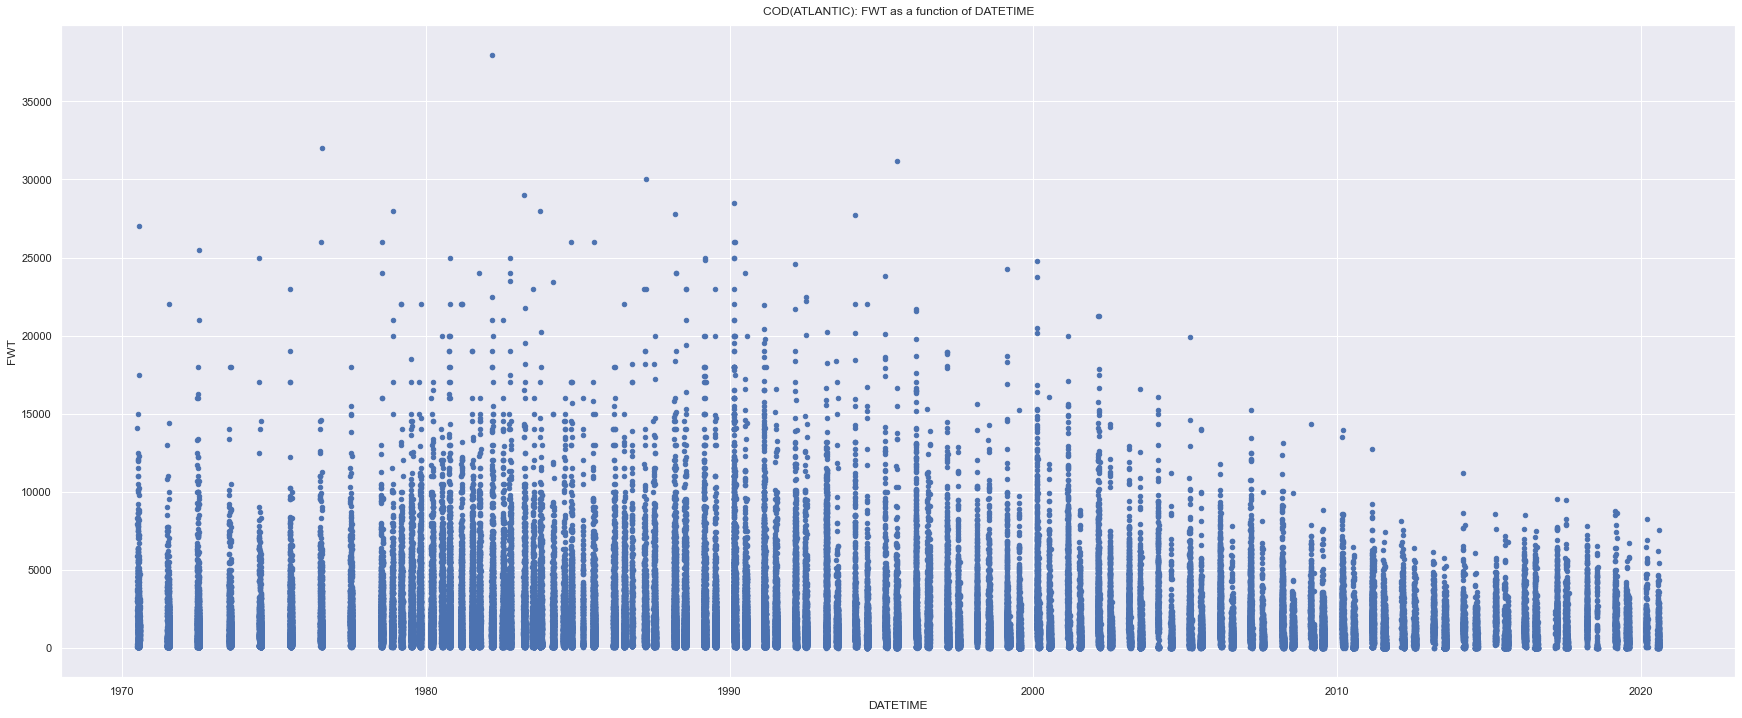

In [42]:
scatterplot_species(df, 10, y='FWT')

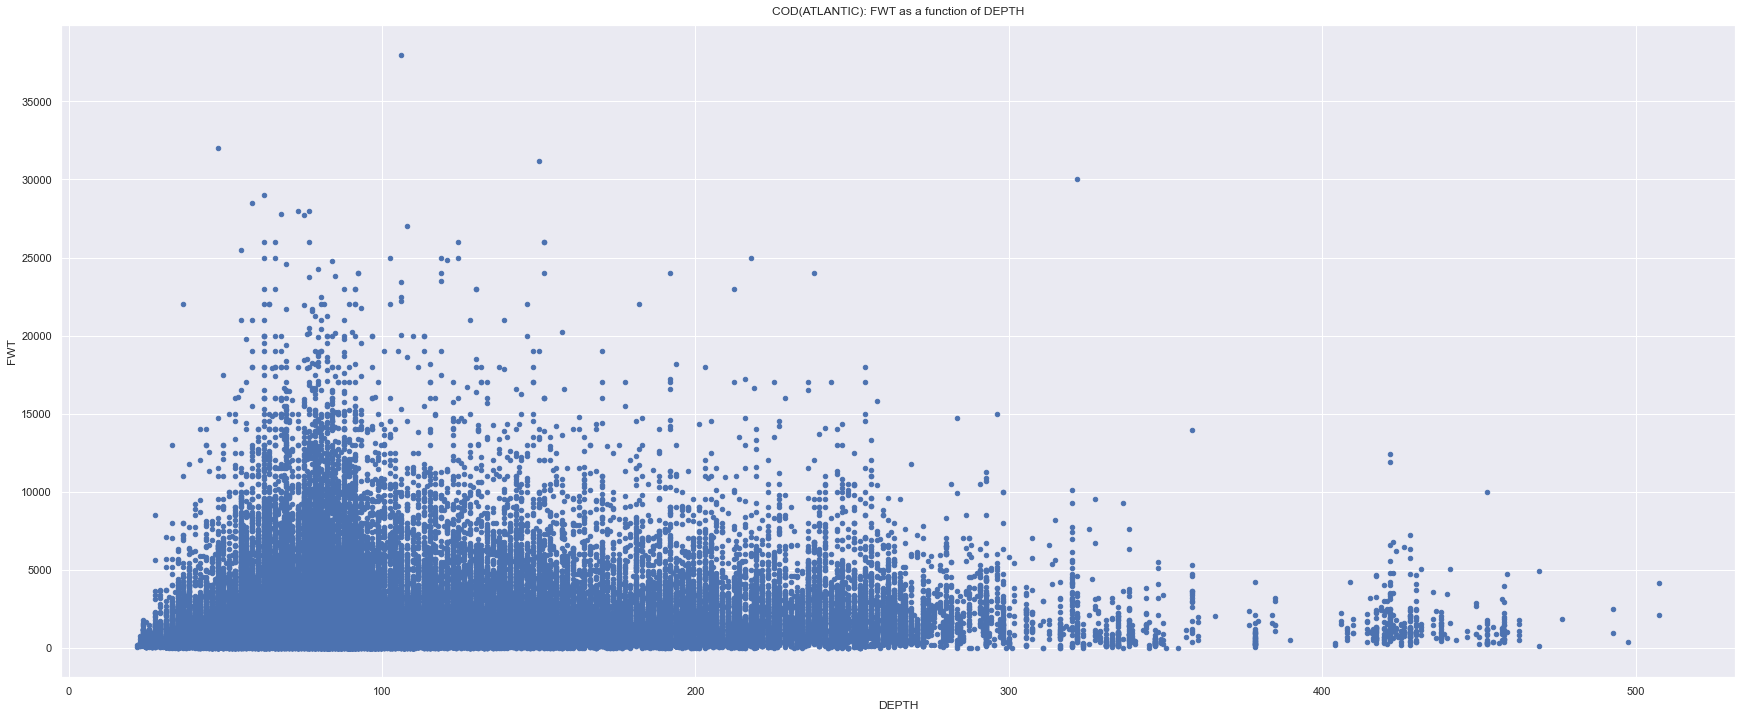

In [43]:
scatterplot_species(df, 10, x='DEPTH', y='FWT')

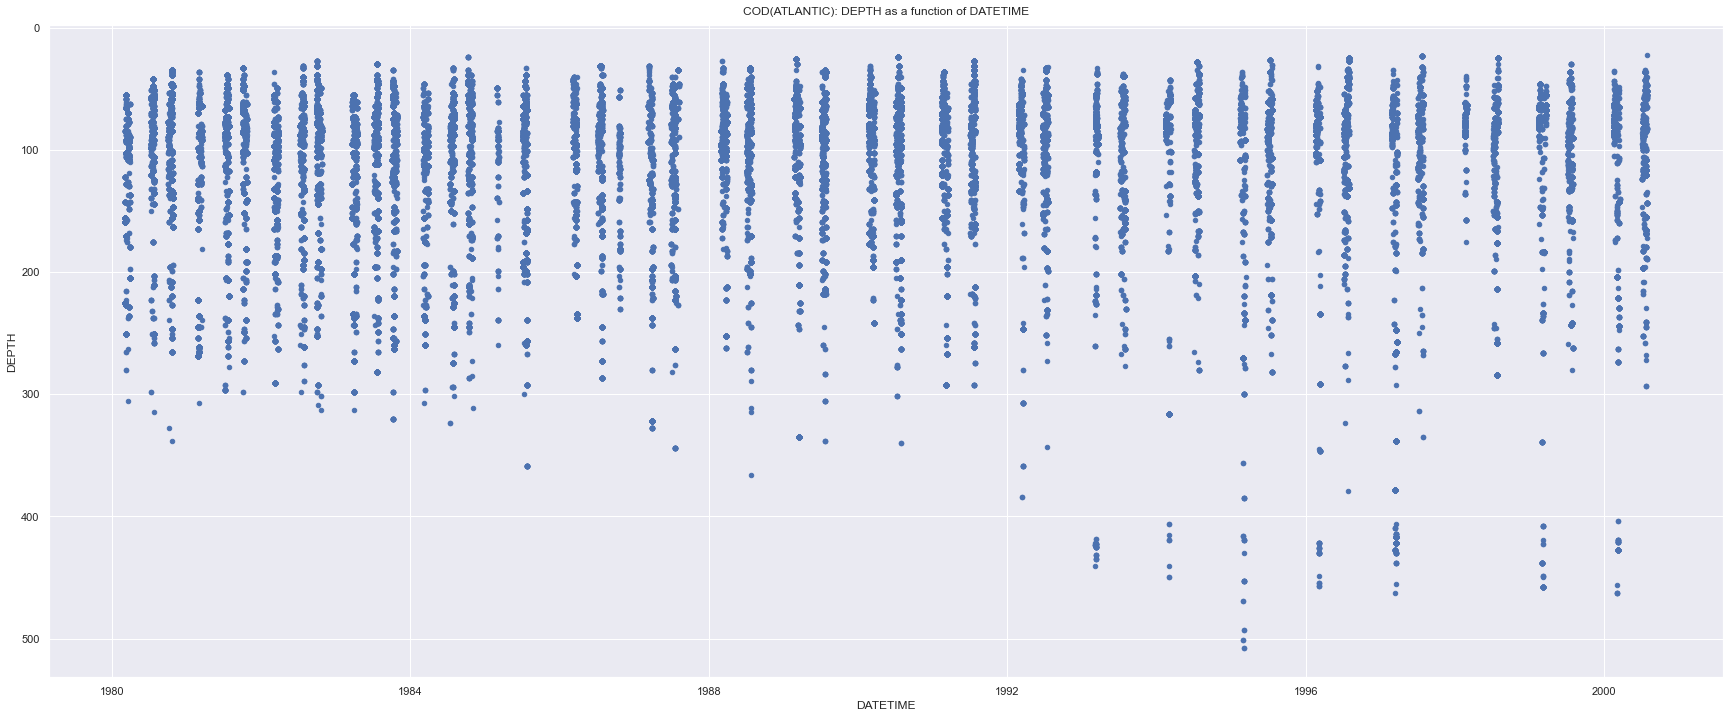

In [44]:
scatterplot_species(df, 10, date_min='1980', date_max='2001')

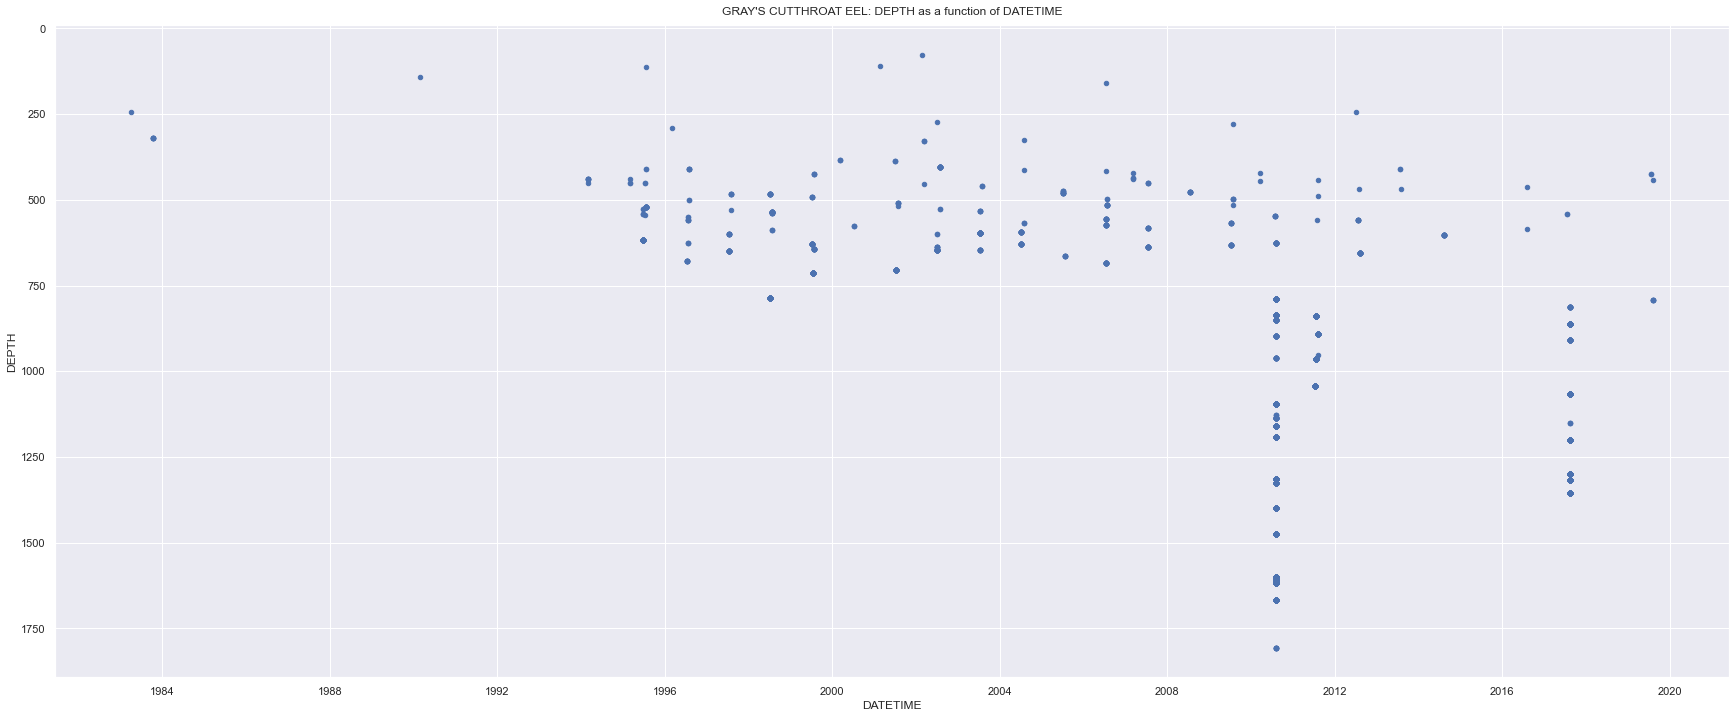

In [45]:
scatterplot_species(df, 602)

In [94]:
def geo_species(dataframe, species_code, date_min=None, date_max=None):
    """
    date_min and date_max are strings, formatted to be interpreted by pandas to_datetime() function
    """
    species_mapping_columns = ['DATETIME', 'SPEC', 'FLEN', 'FWT', 'MATURITY', 'SEX', 'AGE', 
                   'SLAT', 'SLONG', 'ELAT', 'ELONG',  # these are averaged to get LAT, LONG
                   'STRAT', 'DUR', 'DIST', 'SPEED', 'DEPTH', 'SURF_TEMP', 'BOTT_TEMP', 'BOTT_SAL']  # tow info
    
    # create dataframe with full dates
    map_df = average_geo(dataframe[species_mapping_columns][dataframe.SPEC == species_code])
    map_df = filter_dates(map_df, date_min, date_max)

    return map_df


In [98]:
# test mapping
# let's try plotly express!!
import plotly.express as px

In [115]:
gdf = geo_species(df, 10).head(10000)

In [116]:
fig = px.scatter_geo(
    gdf, 
    lat='LAT', 
    lon='LONG', 
    color='DEPTH', 
    projection='natural earth', 
    scope='north america'
)
fig.update_geos(resolution=50)

### Optional Functions

In [ ]:
def map_missions(mission_code, date_range=None):
    pass


def query_by_location(lat, long, radius_in_km):
    pass